In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import os
import utils
from make_data import MakeData
import getdist
from getdist import plots, MCSamples
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
names_planck  = ['H0_gp', 'omega_m', 's80', 'S80']
labels_planck = [r'H_0', r'\omega_{\rm{m}}', r'\sigma_{\rm{8}}',  r'\S_{\rm{8}}']

planck1 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_1.txt')
planck2 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_2.txt')
planck3 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_3.txt')
planck4 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_4.txt')

planck_tot = np.concatenate((planck1, planck2, planck3, planck4), axis=0)

planck_params = []
for item in planck_tot:
    planck_params.append([item[29], item[32], item[34], item[35]])
planck_params = np.array(planck_params)
planck_samples = MCSamples(samples=planck_params, names = names_planck, labels = labels_planck, label= r'$Planck$ 2018',
                    weights=np.transpose(planck_tot)[0],loglikes=np.transpose(planck_tot)[1])

Removed no burn in


In [3]:
z_max = 1110
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaimerz/PhD/Growz/data/products/cosmo4_seed1004/'

data_class = MakeData(z_max, res , path)
Planck = data_class.Planck
z_planck = data_class.z_planck
c = data_class.c

DESI_data = data_class.get_DESI(new=False, mode=None)
WFIRST_data = data_class.get_WFIRST(new=False)
CC_data = data_class.get_CC(new=False)
DSS_data = data_class.get_DSS(new=False)
BOSS_data = data_class.get_BOSS(new=False)
eBOSS_data = data_class.get_eBOSS(new=False)
Wigglez_data = data_class.get_Wigglez(new=False)
DS17_data = data_class.get_DS17(new=False)
CMB_data = data_class.get_CMB(new=False)
FCMB_data = data_class.get_FCMB(new=False)

Found file for DESI
Found file for WFIRST
Found file for CC
Found file for DSS
Found file for BOSS
Found file for eBOSS
Found file for Wigglez
Found file for DS17
Found file for CMB
Found file for FCMB


In [4]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [8]:
#LCDM 
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'LCDM/'
fiducial_LCDM = np.load(os.path.join(path,'LCDM_All_CMB_10000_10000/samples.npz'))
DESI_CMB_LCDM = np.load(os.path.join(path,'LCDM_DESI_CMB_10000_10000/samples.npz'))
nogp_fiducial = np.load(os.path.join(path,'nogp_All_CMB_10000_10000/samples.npz'))

#Fiducials
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'fiducial/'
All = np.load(os.path.join(path,'All_10000_10000/samples.npz'))
All_gro = np.load(os.path.join(path,'All_gro_30000_30000/samples.npz'))
All_CMB = np.load(os.path.join(path,'All_CMB_50000_50000/samples.npz'))
All_CMB_NODSS = np.load(os.path.join(path,'All_CMB_NODSS_10000_10000/samples.npz'))
All_CMB_geo = np.load(os.path.join(path,'All_CMB_geo_30000_30000/samples.npz'))
All_CMB_gro = np.load(os.path.join(path,'All_CMB_gro_30000_30000/samples.npz'))
All_CMB_gro_CMB = np.load(os.path.join(path,'All_CMB_gro_30000_30000/samples.npz'))
SDSS_CMB = np.load(os.path.join(path,'SDSS_CMB_30000_30000/samples.npz'))
Add_CMB = np.load(os.path.join(path,'Add_CMB_30000_30000/samples.npz'))

#Forecasts
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'forecast/'
DESI_gro = np.load(os.path.join(path,'DESI_gro_10000_10000/samples.npz'))
DESI_gro_nowm = np.load(os.path.join(path,'DESI_gro_nowm_10000_10000/samples.npz'))
DESI_CMB = np.load(os.path.join(path,'DESI_CMB_10000_10000/samples.npz'))
DESI_CMB_nowm = np.load(os.path.join(path,'DESI_CMB_nowm_10000_10000/samples.npz'))
DESI_CMB_geo = np.load(os.path.join(path,'DESI_CMB_geo_10000_10000/samples.npz'))
WFIRST_CMB = np.load(os.path.join(path,'WFIRST_CMB_10000_10000/samples.npz'))

#Alternatives
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'alternative/'
All_CMB_hp = np.load(os.path.join(path,'All_CMB_hp_10000_10000/samples.npz'))
All_CMB_gro_hp = np.load(os.path.join(path,'All_CMB_gro_hp_10000_10000/samples.npz'))
All_CMB_geo_hp = np.load(os.path.join(path,'All_CMB_geo_hp_30000_30000/samples.npz'))
#All_CMB_fm = np.load(os.path.join(path,'All_CMB_fm_10000_10000/samples.npz'))
All_CMB_nowm = np.load(os.path.join(path,'All_CMB_nowm_10000_10000/samples.npz'))
All_gro_nowm = np.load(os.path.join(path,'All_gro_nowm_10000_10000/samples.npz'))
All_gro_tight = np.load(os.path.join(path,'All_gro_10eta_10000_10000/samples.npz'))

#Wm
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'Wm/'
All_CMB_Wm = np.load(os.path.join(path,'All_CMB_Planck_30000_30000/samples.npz'))
All_CMB_Wm_hp = np.load(os.path.join(path,'All_CMB_Planck_hp_15000_15000/samples.npz'))
All_CMB_Wm_fm = np.load(os.path.join(path,'All_CMB_Planckfm_15000_15000/samples.npz'))
All_CMB_Wm_A0 = np.load(os.path.join(path,'All_CMB_Planck_WmA0_15000_15000/samples.npz'))
All_CMB_Wm_bf = np.load(os.path.join(path,'All_CMB_bf_15000_15000/samples.npz'))
All_CMB_noWm = np.load(os.path.join(path,'All_CMB_PlancknoWm_15000_15000/samples.npz'))
All_CMB_NODSS_Wm = np.load(os.path.join(path,'All_CMB_NODSS_Wm_30000_30000/samples.npz'))
All_Wm = np.load(os.path.join(path,'All_Wm_15000_15000/samples.npz'))
All_gro_Wm = np.load(os.path.join(path,'All_gro_Wm_15000_15000/samples.npz'))
All_gro_noWm = np.load(os.path.join(path,'All_gro_noWm_15000_15000/samples.npz'))
DESI_CMB_Wm = np.load(os.path.join(path,'DESI_CMB_Wm_30000_30000/samples.npz'))
Add_CMB_Wm = np.load(os.path.join(path,'Add_CMB_Wm_30000_30000/samples.npz'))
SDSS_CMB_Wm = np.load(os.path.join(path,'SDSS_CMB_Wm_30000_30000/samples.npz'))
All_CMB_noWm_bf = np.load(os.path.join(path,'All_CMB_best_fitnoWm_15000_15000/samples.npz'))
All_gro_noWm_bf = np.load(os.path.join(path,'All_gro_best_fit_noWm_15000_15000/samples.npz'))

#Fixed_l
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'Fixed_l/'
All_CMB_Wm_bf_hp2 = np.load(os.path.join(path,'All_CMB_best_fit_l_00001_15000_15000/samples.npz'))
All_CMB_geo_Wm_bf_hp2 = np.load(os.path.join(path,'All_CMB_geo_best_fit_l_00001_15000_15000/samples.npz'))
cosmo10_hp2 = np.load(os.path.join(path,'All_CMB_Planck_cosmo10_l_00001_15000_15000/samples.npz'))
cosmo10_geo_hp2 = np.load(os.path.join(path,'All_CMB_geo_Planck_cosmo10_l_00001_15000_15000/samples.npz'))
cosmo10_hp = np.load(os.path.join(path,'All_CMB_Planck_cosmo10_l_00001_n_01_15000_15000/samples.npz'))
cosmo10_geo_hp = np.load(os.path.join(path,'All_CMB_geo_Planck_cosmo10_l_00001_n_01_15000_15000/samples.npz'))
cosmo10_noWmnos8_hp2 = np.load(os.path.join(path,'All_CMB_Planck_cosmo10_noWm_nos8_l_00001_15000_15000/samples.npz'))

All_CMB_Wm_hp2 = np.load(os.path.join(path,'All_CMB_Planck_l_0001_10000_10000/samples.npz'))
All_CMB_geo_Wm_hp2 = np.load(os.path.join(path,'All_CMB_geo_Planck_l_0001_10000_10000/samples.npz'))
All_CMB_Wm_hp = np.load(os.path.join(path,'All_CMB_Planck_l_00001_n_01_15000_15000/samples.npz'))
All_CMB_geo_Wm_hp = np.load(os.path.join(path,'All_CMB_geo_Planck_l_00001_n_01_15000_15000/samples.npz'))
DESI_CMB_Wm_hp2 = np.load(os.path.join(path,'DESI_CMB_Planck_l_00001_10000_10000/samples.npz'))
DESI_CMB_geo_Wm_hp2 = np.load(os.path.join(path,'DESI_CMB_geo_Planck_l_00001_10000_10000/samples.npz'))
DESI_CMB_Wm_hp3 = np.load(os.path.join(path,'DESI_CMB_Planck_l_00001_n_01_10000_10000/samples.npz'))
DESI_CMB_geo_Wm_hp3 = np.load(os.path.join(path,'DESI_CMB_geo_Planck_l_00001_n_01_10000_10000/samples.npz'))

#Challenge
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'challenge/'
cosmo44_A0 = np.load(os.path.join(path,'cosmo4/All_CMB_Planck_cosmo44A0_15000_15000/samples.npz'))
cosmo44_bf = np.load(os.path.join(path,'cosmo4/All_CMB_other_cosmo44_15000_15000/samples.npz'))
cosmo43_A0 = np.load(os.path.join(path,'cosmo4/All_CMB_Planck_cosmo43A0_15000_15000/samples.npz'))
cosmo43_bf = np.load(os.path.join(path,'cosmo4/All_CMB_other_cosmo43_15000_15000/samples.npz'))
cosmo44 = np.load(os.path.join(path,'cosmo4/All_CMB_cosmo44_10000_10000/samples.npz'))
cosmo43 = np.load(os.path.join(path,'cosmo4/All_CMB_cosmo43_10000_10000/samples.npz'))
LCDM_cosmo40 = np.load(os.path.join(path,'cosmo4/freewb/LCDM_freewb_All_CMB_Planck_cosmo40_15000_15000/samples.npz'))
LCDM_cosmo41 = np.load(os.path.join(path,'cosmo4/freewb/LCDM_freewb_All_CMB_Planck_cosmo41_15000_15000/samples.npz'))
LCDM_cosmo42 = np.load(os.path.join(path,'cosmo4/freewb/LCDM_freewb_All_CMB_Planck_cosmo42_15000_15000/samples.npz'))
LCDM_cosmo43 = np.load(os.path.join(path,'cosmo4/freewb/LCDM_freewb_All_CMB_Planck_cosmo43_15000_15000/samples.npz'))
LCDM_cosmo44 = np.load(os.path.join(path,'cosmo4/freewb/LCDM_freewb_All_CMB_Planck_cosmo44_15000_15000/samples.npz'))

In [79]:
Wm = np.mean(fiducial_LCDM['Omega_m'])
wb = np.mean(fiducial_LCDM['omega_b'])
H0 = np.mean(fiducial_LCDM['H0_gp'])

In [83]:
Wb = wb/(H0/100)**2
Wb

0.04797047569680625

In [86]:
sigma8 = np.mean(fiducial_LCDM['s80'])
sigma8

0.7864801966200743

# Numbers

In [9]:
def table_numbers(samples, sample_names):
    for i, sample in enumerate(samples):
        print(sample_names[i])
        #if 'n' in sample.files:
        #    n = sample['n']
        #    n_m = np.mean(n)
        #    n_s = np.std(n)
        #    print('n', n_m, '+/-', n_s)
        if 'H0_gp' in sample.files:
            H0 = sample['H0_gp']
            H0_m = np.mean(H0)
            H0_s = np.std(H0)
            print('H0', H0_m, '+/-', H0_s)
        if 'S80' in sample.files:
            S80 = sample['S80']
            S80_m = np.mean(S80)
            S80_s = np.std(S80)
            print('S80', S80_m, '+/-', S80_s)
        if 's80' in sample.files:
            s80 = sample['s80']
            s80_m = np.mean(s80)
            s80_s = np.std(s80)
            print('s80', s80_m, '+/-', s80_s)
        if 'omega_m' in sample.files:
            wm = sample['omega_m']
            wm_m = np.mean(wm)
            wm_s = np.std(wm)  
            print('wm0', wm_m, '+/-', wm_s)
        if 'Omega_m' in sample.files:
            wm = sample['Omega_m']
            wm_m = np.mean(wm)
            wm_s = np.std(wm)  
            print('Wm0', wm_m, '+/-', wm_s)
        print('-----')

In [10]:
table_numbers([fiducial_LCDM, All_CMB_Wm, All_Wm, All_CMB_NODSS_Wm,  All_CMB_Wm_fm, All_CMB_Wm_hp,
               All_gro_Wm, SDSS_CMB_Wm, Add_CMB_Wm, DESI_CMB_Wm],
              ['LCDM', 'All_CMB', 'All', 'All_CMB_NODSS', 'All_CMB_fm', 'All_CMB_hp', 
                'All_gro', 'SDSS_CMB', 'Add_CMB', 'DESI_CMB'])

LCDM
H0 68.33264236276125 +/- 0.5306033082125888
S80 0.7847184667858675 +/- 0.028628860586771932
s80 0.7864801966200743 +/- 0.028354541516248232
Wm0 0.29873875090920504 +/- 0.007356181408164363
-----
All_CMB
H0 67.83261857657565 +/- 0.9061843077716045
S80 0.799454757701209 +/- 0.029809593370907567
s80 0.9713244057867932 +/- 0.16153986016103086
Wm0 0.21733960352414602 +/- 0.0630159852623489
-----
All
H0 68.23579346181072 +/- 0.6585029496545665
S80 0.7871681812124215 +/- 0.02959524567891079
s80 0.9192919278286507 +/- 0.15181690509271742
Wm0 0.23556525285068874 +/- 0.06976240364023206
-----
All_CMB_NODSS
H0 67.8430986158397 +/- 0.93201761195686
S80 0.8088264724314915 +/- 0.047692982691856345
s80 0.9777288810492524 +/- 0.21707773700679905
Wm0 0.23868383496904774 +/- 0.1140158486617756
-----
All_CMB_fm
H0 67.41668851901021 +/- 0.5466800049689039
S80 0.7963340469873875 +/- 0.02925692207609573
s80 1.0246895944699719 +/- 0.21285010096584833
Wm0 0.20238586145280954 +/- 0.07577507113686506
-----

# 1D Comp

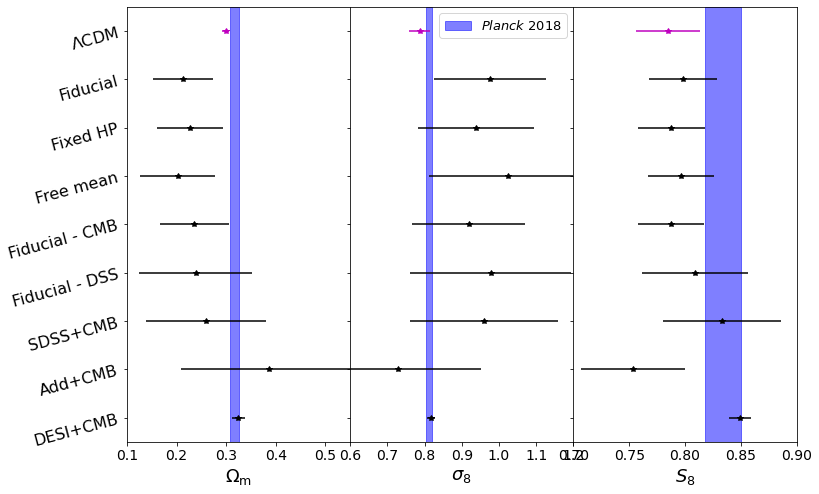

In [11]:
fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace=0)

y = [0, 2,
     4, 6,
     8, 10,
     12, 14, 16,]

my_yticks = ['$\Lambda$CDM', 'Fiducial',
             'Fixed HP', 'Free mean',
             'Fiducial - CMB', 'Fiducial - DSS',
            'SDSS+CMB', 'Add+CMB', 'DESI+CMB']

ax1 = plt.subplot(131)
label = r'$\Omega_{\rm{m}}$'
Wm = [0.29873875090920504, 0.21316049071532125,
     0.22668972081491864, 0.20238586145280954,
     0.23556525285068874, 0.23868383496904774,
     0.2594932911092071, 0.38589987764452055, 0.3244335901354167]
Wm_err = [0.007356181408164363, 0.060173010039542986,
         0.0663848298641342,  0.07577507113686506,
         0.06976240364023206, 0.1140158486617756,
         0.12023443638190157, 0.17706660123084578, 0.013588410952320272]

plt.axvspan(0.3166 - 0.0084, 0.3166 + 0.0084, alpha = 0.5, color='b',  label= r'$Planck$ 2018')
plt.errorbar( Wm[0], y[0], xerr=np.transpose(Wm_err[0]), fmt='m.')
plt.plot( Wm[0], y[0], 'm*')
plt.errorbar( Wm[1:], y[1:], xerr=np.transpose(Wm_err[1:]), fmt='k.')
plt.plot( Wm[1:], y[1:], 'k*')
plt.xlabel(label, fontsize=18)
#plt.legend(loc = 1, prop={'size': 13})
plt.axis([0.1, 0.55,  y[-1]+1 ,-1,])
plt.yticks(y, my_yticks, fontsize=16)
plt.yticks(rotation=15)
plt.xticks(fontsize=14)

    
ax2 = plt.subplot(132, sharey = ax1)
label = r'$\sigma_{\rm{8}}$'
s8 = [0.7864801966200743, 0.9757635474451882,
      0.9378330410146911, 1.0246895944699719, 
      0.9192919278286507,  0.9777288810492524,
      0.959568842637089, 0.7288171883393613, 0.8174332318560756]
s8_err = [0.028354541516248232, 0.15169953387651341,
          0.15588186301145296, 0.21285010096584833,
          0.15181690509271742, 0.21707773700679905,
          0.19936189643156632, 0.2218710327592538, 0.01047930363149866]
plt.axvspan(0.8120 - 0.0073, 0.8120 + 0.0073, alpha = 0.5, color='b',  label= r'$Planck$ 2018')
plt.errorbar( s8[0], y[0], xerr=np.transpose(s8_err[0]), fmt='m.')
plt.plot( s8[0], y[0], 'm*')
plt.errorbar( s8[1:], y[1:], xerr=np.transpose(s8_err[1:]), fmt='k.')
plt.plot( s8[1:], y[1:], 'k*')
plt.xlabel(label, fontsize=18)
plt.legend(loc = 1, prop={'size': 13})
plt.axis([0.6, 1.2,  y[-1]+1 ,-1,])
plt.setp( ax2.get_yticklabels(), visible=False)
plt.xticks(fontsize=14)
    
ax3 = plt.subplot(133, sharey = ax2)
label = r'$S_{\rm{8}}$'
S8 = [0.7847184667858675, 0.7979043356505083,
      0.7878839703161511,  0.7963340469873875,
      0.7871681812124215, 0.8088264724314915,
      0.833077159290144, 0.7534791853895892, 0.8496867477418261]

S8_err = [0.028628860586771932, 0.030435775912380846,
          0.03037692209172309, 0.02925692207609573,
          0.02959524567891079, 0.047692982691856345,
          0.052742237377194724, 0.04622695355145099, 0.009831380826711601]
plt.axvspan(0.834 - 0.016, 0.834 + 0.016, alpha = 0.5, color='b',  label= r'$Planck$ 2018')
plt.errorbar( S8[0], y[0], xerr=np.transpose(S8_err[0]), fmt='m.')
plt.plot( S8[0], y[0], 'm*')
plt.errorbar(S8[1:], y[1:], xerr=np.transpose(S8_err[1:]), fmt='k.')
plt.plot( S8[1:], y[1:], 'k*')
plt.xlabel(label, fontsize=18)
#plt.legend(loc = 1, prop={'size': 13})
plt.axis([0.7, 0.9,  y[-1]+1 ,-1,])
plt.setp( ax3.get_yticklabels(), visible=False)
plt.xticks(fontsize=14)

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/1D_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/1D_comp.pdf')

# Tensions

In [12]:
def get_tensions(ref, names, values):
    for i, value in enumerate(values):
        p_mean = ref[0]
        p_sig = ref[1]**(2)
        means = value[0]
        sigs = value[1]**(2)
        tension = np.abs(p_mean-means)/np.sqrt(p_sig + sigs)
        print(names[i], 'vs Planck:', tension)
    return

In [13]:
get_tensions([0.832, 0.013], my_yticks, np.transpose([S8,S8_err]))

$\Lambda$CDM vs Planck: 1.5037605500197742
Fiducial vs Planck: 1.0302091098470658
Fixed HP vs Planck: 1.3351601110290487
Free mean vs Planck: 1.11403487811149
Fiducial - CMB vs Planck: 1.3869265047747563
Fiducial - DSS vs Planck: 0.4687866767764568
SDSS+CMB vs Planck: 0.019829610981160817
Add+CMB vs Planck: 1.6351651424667355
DESI+CMB vs Planck: 1.0851458831571115


# Triangle Plots

In [40]:
def make_samples(file, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            labels.append(labels_dict[name]) 
            samples.append(file[name]) 
            
        if 'omega_m' in file.keys() and 'H0_gp' in file.keys():
            namess.append('Omega_m')
            labels.append('\Omega_m')
            samples.append(file['omega_m']/(file['H0_gp']/100)**2)
        
        if 'Omega_m' in file.keys() and 'H0_gp' in file.keys():
            namess.append('omega_m')
            labels.append('\omega_m')
            samples.append(file['Omega_m']*(file['H0_gp']/100)**2)
        
        
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3})

In [41]:
def make_samples_avg(files, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        for file in files:
            if name in file.keys():
                namess.append(name) 
                labels.append(labels_dict[name]) 
                samples.append(file[name]) 
        
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3})

In [42]:
labels_dict = {'n': '\eta',
               'l': 'l',
               'A0': 'A_0',
               'n_H': '\eta_H',
               'l_H': 'l_H',
               'n_Xi': '\eta_{Xi}',
               'l_Xi': 'l_{Xi}',
               'H0': 'H_0',
               'H0_gp': 'H_0',
               'omega_m': '\omega_m',
               'Omega_m': '\Omega_m',
               'Omega_m_mean': '\Omega_m^{mean}',
               'omega_b': '\omega_b',
               'Omega_m': '\Omega_m',
               'Omega_b': '\Omega_b',
               's80': '\sigma_8',
               'S80': 'S_8',
               'M': 'M'}
names_All = ['n', 'l', 'n_H', 'l_H', 'n_Xi', 'l_Xi', 'A0',
             'H0', 'H0_gp',  'Omega_m', 'omega_m', 'Omega_m_mean',
             'omega_b', 'Omega_m', 'Omega_b', 's80', 'S80', 'M']
#ranges = {'l':[0.001, 7], 'omega_b': [0.022, 0.023]}
ranges = {'l':[0.001, 7], 'Omega_m':[0.00, 0.4]}

In [67]:
WFIRST_CMB_samples = make_samples(WFIRST_CMB, ['n', 'l', 'H0_gp', 'omega_m',  'omega_b'], ranges, 'WFIRST+CMB')
DESI_CMB_Wm_samples = make_samples(DESI_CMB_Wm, ['n', 'l', 'H0_gp', 'Omega_m',  'omega_b', 's80', 'S80'], ranges, 'DESI+CMB')
DESI_CMB_geo_samples = make_samples(DESI_CMB_geo, ['n', 'l', 'H0_gp', 'omega_m'], ranges, 'DESI+CMB_geo')
fiducial_LCDM_samples = make_samples(fiducial_LCDM, ['H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, r'Fiducial - $\Lambda$CDM')
DESI_CMB_LCDM_samples = make_samples(DESI_CMB_LCDM, ['H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, r' DESI+CMB - $\Lambda$CDM')
nogp_samples = make_samples(nogp_fiducial, ['H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, r'$\Lambda$CDM')
All_Wm_samples = make_samples(All_Wm, ['l', 'H0', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'No CMB')
All_CMB_Wm_samples = make_samples(All_CMB_Wm, ['n', 'l', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'Fiducial_Wm')
All_CMB_noWm_bf_samples = make_samples(All_CMB_noWm_bf, ['n', 'l', 'H0_gp', 'omega_b', 's80', 'S80'], ranges, 'All_noWm_bf')
All_CMB_hp_samples = make_samples(All_CMB_hp, ['H0_gp', 'omega_b', 'omega_m', 's80', 'S80'],
                                      ranges, 'Fixed HP')
All_CMB_Wm_hp2_samples = make_samples(All_CMB_Wm_hp2, ['n'],
                                      ranges, 'All - Fixed l')
All_CMB_geo_Wm_hp2_samples = make_samples(All_CMB_geo_Wm_hp2, ['n'],
                                      ranges, 'All geo - Fixed l')
#All_CMB_fm_samples = make_samples(All_CMB_fm, ['n', 'l', 'H0_gp', 'omega_b', 'Omega_m', 'Omega_m_mean', 's80', 'S80'],
#                                           ranges, 'Free $\Omega_m^{mean}$')
All_CMB_Wm_fm_samples = make_samples(All_CMB_Wm_fm, ['n', 'l', 'H0_gp', 'omega_b', 'Omega_m', 'Omega_m_mean', 's80', 'S80'],
                                           ranges, 'Free $\Omega_m^{mean}$')
All_CMB_geo_samples = make_samples(All_CMB_geo, ['n', 'l', 'H0_gp', 'omega_b'],
                                           ranges, 'Geometry data')
All_gro_Wm_samples = make_samples(All_gro_Wm, ['n', 'l', 'H0_gp', 'Omega_m', 'omega_m', 's80', 'S80'],
                                           ranges, 'Growth data Wm')
All_gro_samples = make_samples(All_gro, ['n', 'l', 'H0_gp', 'Omega_m','omega_m', 's80', 'S80'],
                                           ranges, 'Growth data Wm')
All_gro_noWm_samples = make_samples(All_gro_noWm, ['n', 'l', 'H0_gp'],
                                           ranges, 'Growth data noWm')
All_CMB_Wmean_samples = MCSamples(samples=[All_CMB_Wm_fm['l'], All_CMB_Wm_fm['Omega_m_mean']], names=['l', 'Omega_m'],
                                  labels=['l','\omega_m'],label='Geometry data', ranges=ranges)
SDSS_CMB_Wm_samples = make_samples(SDSS_CMB_Wm, ['n', 'l', 'H0_gp', 'Omega_m', 'omega_b', 's80', 'S80'], 
                                      ranges, 'SDSS+CMB_Wm')
Add_CMB_Wm_samples = make_samples(Add_CMB_Wm, ['n', 'l', 'H0_gp', 'Omega_m', 'omega_b', 's80', 'S80'], 
                                      ranges, 'Add+CMB_Wm')

cosmo44_samples = make_samples(cosmo44, ['n', 'l', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'cosmo44')
cosmo44_A0_samples = make_samples(cosmo44_A0, ['n', 'l', 'A0', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'cosmo44_A0')
cosmo44_bf_samples = make_samples(cosmo44_bf, ['n', 'l', 'A0', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'cosmo44_bf')
LCDM_cosmo44_samples = make_samples(LCDM_cosmo44, ['n', 'l', 'A0', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'LCDM_cosmo44')

cosmo43_samples = make_samples(cosmo43, ['n', 'l', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'cosmo43')
cosmo43_A0_samples = make_samples(cosmo43_A0, ['n', 'l', 'A0', 'M', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'cosmo43_A0')
cosmo43_bf_samples = make_samples(cosmo43_bf, ['n', 'l', 'A0', 'M', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'cosmo43_bf')
LCDM_cosmo43_samples = make_samples(LCDM_cosmo43, ['n', 'l', 'A0', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'LCDM_cosmo43')


#cosmo1_samples = make_samples(cosmo1, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo1')
#cosmo2_samples = make_samples(cosmo2, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo2')
#cosmo3_samples = make_samples(cosmo3, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo3')
#cosmo4_samples = make_samples(cosmo4, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo4')
#cosmo3b_samples = make_samples(cosmo3b, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo3b')
#cosmo4b_samples = make_samples(cosmo4b, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo4b')
#cosmo5_samples = make_samples(cosmo5, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo5')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [44]:
np.median(All_CMB_geo['l'])

2.0400366336801237

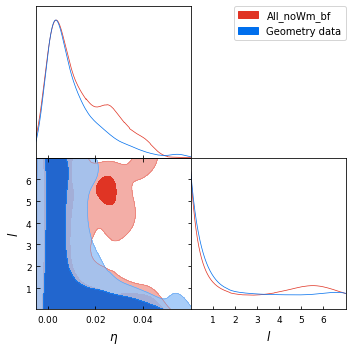

In [68]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_CMB_noWm_bf_samples, All_CMB_geo_samples],
                ['n', 'l'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

## Effect of Growth data

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_CMB_Wm_samples, DESI_CMB_geo_samples],
                ['n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_gro_Wm_samples, All_CMB_Wm_samples],
                ['n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

## Data set break down

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([Add_CMB_Wm_samples,  SDSS_CMB_Wm_samples, All_CMB_Wm_samples, DESI_CMB_Wm_samples],
                ['n', 'l', 'H0_gp', 'Omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                colors = ['grey', 'green', 'red', 'blue'],
                contour_colors = ['grey', 'green', 'red', 'blue'],
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

## Forecasts

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_CMB_Wm_samples, WFIRST_CMB_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                colors = ['blue', 'red'],
                contour_colors = ['blue', 'red'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_forecast.pdf')

## Alternative

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([ All_CMB_Wm_fm_samples, All_CMB_hp_samples, All_CMB_Wm_samples],
                ['n', 'l', 'H0_gp', 'Omega_m', 'Omega_m_mean', 'omega_b', 's80', 'S80'],
                colors = ['blue', 'black',  'red'],
                contour_colors = ['blue', 'black', 'red'],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         'omega_b': data_class.cosmo.Omega_b()*data_class.cosmo.h()**2,
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_tests.pdf')

## Wm vs wm

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([ All_CMB_Wm_hp2_samples, All_CMB_geo_Wm_hp2_samples],
                ['n'],
                colors = ['blue', 'black',  'red'],
                contour_colors = ['blue', 'black', 'red'],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         'omega_b': data_class.cosmo.Omega_b()*data_class.cosmo.h()**2,
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_tests.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_CMB_Wm_samples, fiducial_LCDM_samples],
                ['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_CMB_Wm_samples, DESI_CMB_LCDM_samples],
                ['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_gro_samples, All_gro_Wm_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

## Extra plots

In [ ]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_2d([All_CMB_hp_samples,  All_CMB_Wm_samples, All_CMB_Wm_fm_samples],
          'omega_m', 's80', filled=True,
          colors = ['grey', 'red', 'blue'],
          lims=[0, 0.3, 0.6, 1.55])
g.add_x_marker(0.1202)
g.add_y_marker(0.8120)

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/banana_test.pdf')

In [ ]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_2d([Add_CMB_Wm_samples, SDSS_CMB_Wm_samples, All_CMB_Wm_samples, DESI_CMB_Wm_samples],
          'omega_m', 's80', filled=True, 
           colors = ['grey','green', 'red', 'blue'],
           lims=[0, 0.3, 0.6, 1.55], 
           markers={'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                    's80': data_class.cosmo.sigma8()})
g.add_x_marker(0.1202)
g.add_y_marker(0.8120)

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/banana_data.pdf')

In [ ]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_1d([All_CMB_Wm_fm_samples, All_CMB_Wmean_samples],'Omega_m', 
          colors=['green', 'blue'])
g.add_legend([r'$\Omega_m$', r'$\Omega_m^{mean}$'])
             
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/geovsgro_1D.pdf')

## Challenge

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([cosmo44_A0_samples, All_CMB_Wm_samples, cosmo44_bf_samples, LCDM_cosmo44_samples],
                ['n', 'l', 'H0_gp', 'A0',  'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([cosmo43_A0_samples, cosmo43_samples, cosmo43_bf_samples, LCDM_cosmo43_samples],
                ['n', 'l', 'H0_gp', 'M', 'A0',  'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

In [ ]:
print('H0*A0 :', np.mean(cosmo44_A0['H0_gp'])*np.mean(cosmo44_A0['A0']), '+-', np.std(cosmo44_A0['H0_gp']))
print('best fit LCDM :', np.mean(LCDM_cosmo44['H0_gp']), '+-', np.std(LCDM_cosmo44['H0_gp']))

In [ ]:
from os import listdir
from os.path import isfile, join
path = '/home/jaimerz/PhD/Growz/data/outputs/challenge/cosmo1'
folders = [f for f in listdir(path) if not isfile(join(path, f))]
folders 

In [ ]:
path = '/home/jaimerz/PhD/Growz/data/outputs/challenge/'
os.path.join('path', 'cosmo1')

In [ ]:
def challenge_1(cosmo):
    base_path = os.path.join('/home/jaimerz/PhD/Growz/data/outputs/challenge/', cosmo)
    challenges = [f for f in listdir(base_path) if 'LCDM' not in f]#(not isfile(join(base_path, f))) or ('LCDM' not in f)]
    challenge_samples = []
    for challenge in challenges:
        path = os.path.join(base_path, challenge)+'/samples.npz'
        chain = np.load(path)
        samples = make_samples(chain, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, challenge)
        challenge_samples.append(samples)
    g = plots.getSubplotPlotter(subplot_size=2.5)
    g.triangle_plot(challenge_samples,
                ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                contour_colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})              
    g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')
    return  

In [ ]:
def challenge_LCDM(cosmo):
    base_path = os.path.join('/home/jaimerz/PhD/Growz/data/outputs/challenge/', cosmo)
    base_path = os.path.join(base_path, 'freewb')
    challenges = [f for f in listdir(base_path) if 'LCDM' in f]
    challenge_samples = []
    for challenge in challenges:
        path = os.path.join(base_path, challenge)+'/samples.npz'
        chain = np.load(path)
        samples = make_samples(chain, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, challenge)
        challenge_samples.append(samples)
    g = plots.getSubplotPlotter(subplot_size=2.5)
    g.triangle_plot(challenge_samples,
                ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                contour_colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})              
    g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')
    return  

In [ ]:
def challenge_2():
    cosmos = ['cosmo1', 'cosmo2', 'cosmo3', 'cosmo4', 'cosmo5']
    challenge_samples = []
    for cosmo in cosmos:
        base_path = os.path.join('/home/jaimerz/PhD/Growz/data/outputs/challenge/', cosmo)
        challenges = [f for f in listdir(base_path) if not isfile(join(base_path, f))]
        chains = []
        for challenge in challenges:
            path = os.path.join(base_path, challenge)+'/samples.npz'
            chain = np.load(path)
            if '30000' in challenge:
                pass
            elif '15000' in challenge:
                pass
            else:
                chains.append(chain)
        samples = make_samples_avg(chains, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'],
                                   ranges, cosmo)
        challenge_samples.append(samples)
    g = plots.getSubplotPlotter(subplot_size=2.5)
    g.triangle_plot(challenge_samples,
                ['H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                contour_colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                        'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})              
    g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')
    return

In [ ]:
challenge_2()

In [ ]:
challenge_1('cosmo1')

In [ ]:
challenge_1('cosmo2')

In [ ]:
challenge_1('cosmo3')

In [ ]:
challenge_1('cosmo4')

In [ ]:
challenge_LCDM('cosmo4')

In [ ]:
challenge_1('cosmo5')

In [ ]:
path = '/home/jaimerz/PhD/Growz/data/outputs/challenge/cosmo4/'
cosmo40 = np.load(path+'All_CMB_cosmo40_30000_30000/samples.npz')
cosmo41 = np.load(path+'All_CMB_cosmo41_10000_10000/samples.npz')
cosmo42 = np.load(path+'All_CMB_cosmo42_10000_10000/samples.npz')
cosmo43 = np.load(path+'All_CMB_cosmo43_10000_10000/samples.npz')
cosmo44 = np.load(path+'All_CMB_cosmo44_10000_10000/samples.npz')
#cosmo41 = np.load(path)
#cosmo42 = np.load(path)
#cosmo43 = np.load(path)
#cosmo44 = np.load(path)

path = '/home/jaimerz/PhD/Growz/data/outputs/challenge/cosmo1/'
cosmo10 = np.load(path+'All_CMB_cosmo10_10000_10000/samples.npz')

In [ ]:
#H_cosmo1_m, H_cosmo1_s = get_m_s(cosmo1['Hz'])
H_cosmo1_m, H_cosmo1_s = get_m_s(cosmo10['Hz'])
#H_cosmo2_m, H_cosmo2_s = get_m_s(cosmo2['Hz'])
#H_cosmo3_m, H_cosmo3_s = get_m_s(cosmo3['Hz'])
#H_cosmo3b_m, H_cosmo3b_s = get_m_s(cosmo3b['Hz'])
H_cosmo40_m, H_cosmo40_s = get_m_s(cosmo40['Hz'])
H_cosmo41_m, H_cosmo41_s = get_m_s(cosmo41['Hz'])
H_cosmo42_m, H_cosmo42_s = get_m_s(cosmo42['Hz'])
H_cosmo43_m, H_cosmo43_s = get_m_s(cosmo43['Hz'])
H_cosmo44_m, H_cosmo44_s = get_m_s(cosmo44['Hz'])
H_cosmo44_A0_m, H_cosmo44_A0_s = get_m_s(cosmo44_A0['Hz'])
H_cosmo44_bf_m, H_cosmo44_bf_s = get_m_s(cosmo44_bf['Hz'])
#H_cosmo4b_m, H_cosmo4b_s = get_m_s(cosmo4b['Hz'])
#H_cosmo5_m, H_cosmo5_s = get_m_s(cosmo5['Hz'])


In [ ]:
#plt.plot(z_arr,  H_cosmo40_m, color ='g', label='cosmo40')
#plt.fill_between(z_arr, H_cosmo40_m+H_cosmo40_s,
#                 H_cosmo40_m-H_cosmo40_s, color='g', alpha=.5)

#plt.plot(z_arr,  H_cosmo41_m, color ='k', label='cosmo41')
#plt.fill_between(z_arr, H_cosmo41_m+H_cosmo41_s,
#                 H_cosmo41_m-H_cosmo41_s, color='k', alpha=.5)

#plt.plot(z_arr,  H_cosmo42_m, color ='b', label='cosmo42')
#plt.fill_between(z_arr, H_cosmo42_m+H_cosmo42_s,
#                 H_cosmo42_m-H_cosmo42_s, color='b', alpha=.5)

#plt.plot(z_arr,  H_cosmo43_m, color ='m', label='cosmo43')
#plt.fill_between(z_arr, H_cosmo43_m+H_cosmo43_s,
#                 H_cosmo43_m-H_cosmo43_s, color='m', alpha=.5)

plt.plot(z_arr,  H_cosmo44_m, color ='y', label='cosmo44')
plt.fill_between(z_arr, H_cosmo44_m+H_cosmo44_s,
                 H_cosmo44_m-H_cosmo44_s, color='y', alpha=.5)

plt.plot(z_arr,  H_cosmo44_A0_m, color ='m', label='cosmo44_A0')
plt.fill_between(z_arr, H_cosmo44_A0_m+H_cosmo44_A0_s,
                 H_cosmo44_A0_m-H_cosmo44_A0_s, color='m', alpha=.5)

plt.plot(z_arr,  H_cosmo44_bf_m, color ='g', label='cosmo44_bf')
plt.fill_between(z_arr, H_cosmo44_bf_m+H_cosmo44_bf_s,
                 H_cosmo44_bf_m-H_cosmo44_bf_s, color='g', alpha=.5)

#plt.plot(z_arr,  H_cosmo1_m, color ='r', label='cosmo1')
#plt.fill_between(z_arr, H_cosmo1_m+H_cosmo1_s,
#                 H_cosmo1_m-H_cosmo1_s, color='r', alpha=.5)

plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')


plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

# d_H gp 

In [17]:
dH_DESI_CMB_m, dH_DESI_CMB_s = get_m_s(DESI_CMB_Wm['DHz'])
dH_DESI_gro_m, dH_DESI_gro_s = get_m_s(DESI_gro['DHz'])
dH_DESI_CMB_geo_m, dH_DESI_CMB_geo_s = get_m_s(DESI_CMB_geo['DHz'])
dH_WFIRST_CMB_m, dH_WFIRST_CMB_s = get_m_s(WFIRST_CMB['DHz'])
dH_All_m, dH_All_s = get_m_s(All_Wm['DHz'])
dH_All_gro_m, dH_All_gro_s = get_m_s(All_gro_Wm['DHz'])
dH_All_gro_noWm_m, dH_All_gro_noWm_s = get_m_s(All_gro_noWm['DHz'])
dH_All_gro_noWm_bf_m, dH_All_gro_noWm_bf_s = get_m_s(All_gro_noWm_bf['DHz'])
dH_All_CMB_m, dH_All_CMB_s = get_m_s(All_CMB_Wm['DHz'])
dH_All_CMB_noWm_m, dH_All_CMB_noWm_s = get_m_s(All_CMB_noWm['DHz'])
dH_All_CMB_noWm_bf_m, dH_All_CMB_noWm_bf_s = get_m_s(All_CMB_noWm_bf['DHz'])
dH_All_CMB_hp_m, dH_All_CMB_hp_s = get_m_s(All_CMB_hp['DHz']) #All_CMB_Wm_hp['DHz']
dH_All_CMB_geo_hp_m, dH_All_CMB_geo_hp_s = get_m_s(All_CMB_geo_hp['DHz'])

dH_All_CMB_Wm_hp_m, dH_All_CMB_Wm_hp_s = get_m_s(All_CMB_Wm_hp['DHz'])
dH_All_CMB_geo_Wm_hp_m, dH_All_CMB_geo_Wm_hp_s = get_m_s(All_CMB_geo_Wm_hp['DHz'])
dH_All_CMB_Wm_hp2_m, dH_All_CMB_Wm_hp2_s = get_m_s(All_CMB_Wm_hp2['DHz'])
dH_All_CMB_geo_Wm_hp2_m, dH_All_CMB_geo_Wm_hp2_s = get_m_s(All_CMB_geo_Wm_hp2['DHz'])
dH_All_CMB_Wm_bf_hp2_m, dH_All_CMB_Wm_bf_hp2_s = get_m_s(All_CMB_Wm_bf_hp2['DHz'])
dH_All_CMB_geo_Wm_bf_hp2_m, dH_All_CMB_geo_Wm_bf_hp2_s = get_m_s(All_CMB_geo_Wm_bf_hp2['DHz'])
dH_DESI_CMB_Wm_hp2_m, dH_DESI_CMB_Wm_hp2_s = get_m_s(DESI_CMB_Wm_hp2['DHz'])
dH_DESI_CMB_geo_Wm_hp2_m, dH_DESI_CMB_geo_Wm_hp2_s = get_m_s(DESI_CMB_geo_Wm_hp2['DHz'])
dH_DESI_CMB_Wm_hp3_m, dH_DESI_CMB_Wm_hp3_s = get_m_s(DESI_CMB_Wm_hp3['DHz'])
dH_DESI_CMB_geo_Wm_hp3_m, dH_DESI_CMB_geo_Wm_hp3_s = get_m_s(DESI_CMB_geo_Wm_hp3['DHz'])
dH_cosmo10_hp2_m, dH_cosmo10_hp2_s = get_m_s(cosmo10_hp2['DHz'])
dH_cosmo10_noWmnos8_hp2_m, dH_cosmo10_noWmnos8_hp2_s = get_m_s(cosmo10_noWmnos8_hp2['DHz'])
dH_cosmo10_geo_hp2_m, dH_cosmo10_geo_hp2_s = get_m_s(cosmo10_geo_hp2['DHz'])
dH_cosmo10_hp_m, dH_cosmo10_hp_s = get_m_s(cosmo10_hp['DHz'])
dH_cosmo10_geo_hp_m, dH_cosmo10_geo_hp_s = get_m_s(cosmo10_geo_hp['DHz'])

dH_All_CMB_Wm_fm_m, dH_All_CMB_Wm_fm_s = get_m_s(All_CMB_Wm_fm['DHz'])
dH_All_CMB_geo_m, dH_All_CMB_geo_s = get_m_s(All_CMB_geo['DHz'])
dH_SDSS_CMB_m, dH_SDSS_CMB_s = get_m_s(SDSS_CMB_Wm['DHz'])
dH_Add_CMB_m, dH_Add_CMB_s = get_m_s(Add_CMB_Wm['DHz'])
dH_cosmo44_A0_m, dH_cosmo44_A0_s = get_m_s(cosmo44_A0['DHz'])

Planck = data_class.Planck
z_planck = data_class.z_planck

<ipython-input-50-ac98a451d8d5>:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


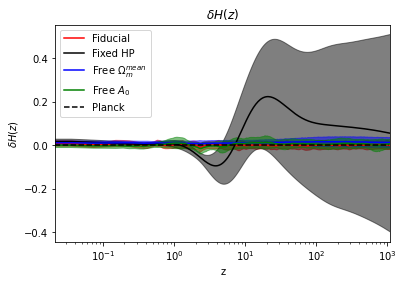

In [50]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_hp_m, color ='k', label='Fixed HP')
plt.fill_between(z_arr, dH_All_CMB_hp_m+dH_All_CMB_hp_s,
                 dH_All_CMB_hp_m-dH_All_CMB_hp_s, color='k', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_Wm_fm_m, color ='b', label='Free $\Omega_m^{mean}$')
plt.fill_between(z_arr, dH_All_CMB_Wm_fm_m+dH_All_CMB_Wm_fm_s,
                 dH_All_CMB_Wm_fm_m-dH_All_CMB_Wm_fm_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_cosmo44_A0_m, color ='g', label='Free $A_0$')
plt.fill_between(z_arr, dH_cosmo44_A0_m+dH_cosmo44_A0_s,
                 dH_cosmo44_A0_m-dH_cosmo44_A0_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')  

<ipython-input-51-19b250b58035>:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


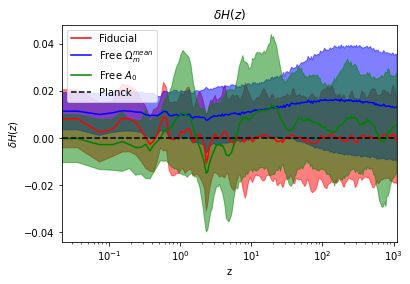

In [51]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

#plt.plot(z_arr,  dH_All_CMB_hp_m, color ='k', label='Fixed HP')
#plt.fill_between(z_arr, dH_All_CMB_hp_m+dH_All_CMB_hp_s,
#                 dH_All_CMB_hp_m-dH_All_CMB_hp_s, color='k', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_Wm_fm_m, color ='b', label='Free $\Omega_m^{mean}$')
plt.fill_between(z_arr, dH_All_CMB_Wm_fm_m+dH_All_CMB_Wm_fm_s,
                 dH_All_CMB_Wm_fm_m-dH_All_CMB_Wm_fm_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_cosmo44_A0_m, color ='g', label='Free $A_0$')
plt.fill_between(z_arr, dH_cosmo44_A0_m+dH_cosmo44_A0_s,
                 dH_cosmo44_A0_m-dH_cosmo44_A0_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')  

<ipython-input-52-f30137a066d6>:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.fill_between(z_arr, dH_SDSS_CMB_m+dH_SDSS_CMB_s,
<ipython-input-52-f30137a066d6>:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


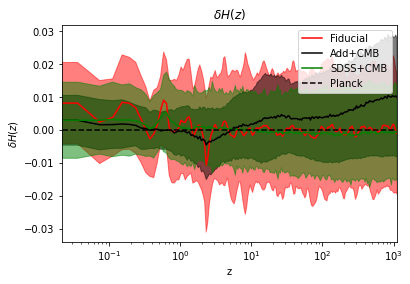

In [52]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_Add_CMB_m, color ='k', label='Add+CMB')
plt.fill_between(z_arr, dH_Add_CMB_m+dH_Add_CMB_s,
                 dH_Add_CMB_m-dH_Add_CMB_s, color='k', alpha=.5)

plt.plot(z_arr,  dH_SDSS_CMB_m, color ='g', label='SDSS+CMB')
plt.fill_between(z_arr, dH_SDSS_CMB_m+dH_SDSS_CMB_s,
                 dH_SDSS_CMB_m-dH_SDSS_CMB_s, color='gk', alpha=.5)

#plt.plot(z_arr,  dH_DESI_CMB_m, color ='b', label='DESI_CMB')
#plt.fill_between(z_arr, dH_DESI_CMB_m+dH_DESI_CMB_s,
#                 dH_DESI_CMB_m-dH_DESI_CMB_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) $")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_data.pdf')  

<ipython-input-66-3a9866c9c55f>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
<ipython-input-66-3a9866c9c55f>:37: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
<ipython-input-66-3a9866c9c55f>:61: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


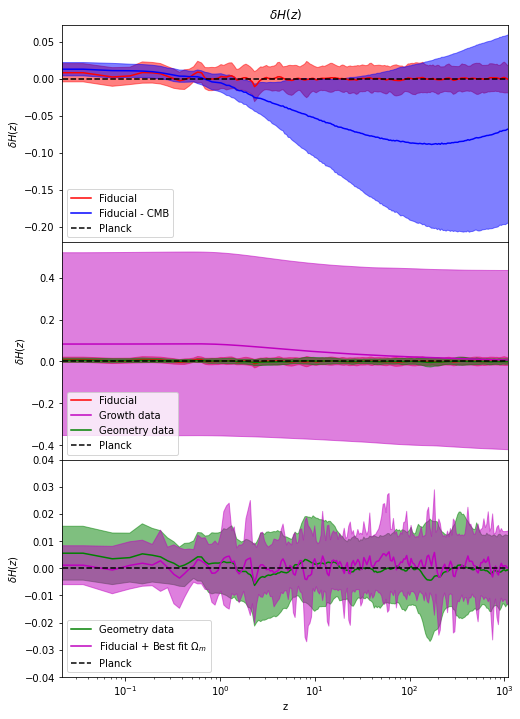

In [66]:
fig=plt.figure(figsize=(8,12))
fig.subplots_adjust(hspace=0)
ax1 = plt.subplot(311)
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_m, color ='b', label='Fiducial - CMB')
plt.fill_between(z_arr, dH_All_m+dH_All_s,
                 dH_All_m-dH_All_s, color='b', alpha=.5)
plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
#plt.ylim(-.04, .04)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')
plt.setp( ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(312, sharex = ax1)
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_gro_m, color ='m', label='Growth data')
plt.fill_between(z_arr, dH_All_gro_m+dH_All_gro_s,
                 dH_All_gro_m-dH_All_gro_s, color='m', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_m, color ='g', label='Geometry data')
plt.fill_between(z_arr, dH_All_CMB_geo_m+dH_All_CMB_geo_s,
                 dH_All_CMB_geo_m-dH_All_CMB_geo_s, color='g', alpha=.5)
plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
#plt.ylim(-.04, .04)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
#plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')
plt.setp( ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(313, sharex = ax1)
#plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
#plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
#                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_m, color ='g', label='Geometry data')
plt.fill_between(z_arr, dH_All_CMB_geo_m+dH_All_CMB_geo_s,
                 dH_All_CMB_geo_m-dH_All_CMB_geo_s, color='g', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_noWm_bf_m, color ='m', label='Fiducial + Best fit $\Omega_m$')
plt.fill_between(z_arr, dH_All_CMB_noWm_bf_m+dH_All_CMB_noWm_bf_s,
                 dH_All_CMB_noWm_bf_m-dH_All_CMB_noWm_bf_s, color='m', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.ylim(-.04, .04)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
#plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf')  

In [65]:
print('All', np.mean(All_CMB_Wm['n']), '+/-', np.std(All_CMB_Wm['n']))
print('All + best fit $\Omega_m$', np.mean(All_CMB_noWm_bf['n']), '+/-', np.std(All_CMB_noWm_bf['n']))
print('All geo', np.mean(All_CMB_geo['n']), '+/-', np.std(All_CMB_geo['n']))

All 0.015921658518687105 +/- 0.013883149918083199
All + best fit $\Omega_m$ 0.013622322137336655 +/- 0.0121040750758622
All geo 0.010801790317043808 +/- 0.011151645271800535


<ipython-input-54-6ebefec5fcff>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
<ipython-input-54-6ebefec5fcff>:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


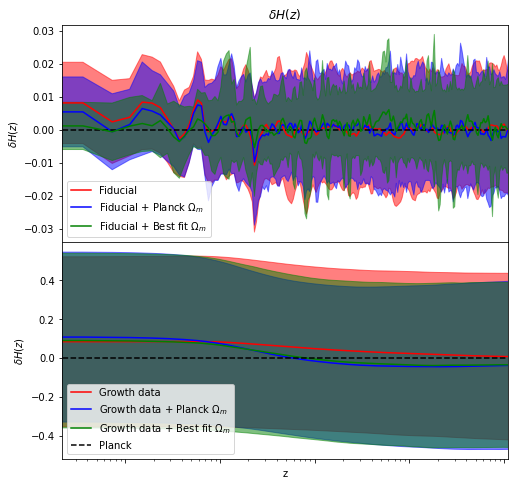

In [54]:
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0)
ax1 = plt.subplot(211)
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_noWm_m, color ='b', label='Fiducial + Planck $\Omega_m$')
plt.fill_between(z_arr, dH_All_CMB_noWm_m+dH_All_CMB_noWm_s,
                 dH_All_CMB_noWm_m-dH_All_CMB_noWm_s, color='b', alpha=.5)
plt.plot(z_planck, np.zeros_like(z_planck), 'k--' )#, label='Planck')

plt.plot(z_arr,  dH_All_CMB_noWm_bf_m, color ='g', label='Fiducial + Best fit $\Omega_m$')
plt.fill_between(z_arr, dH_All_CMB_noWm_bf_m+dH_All_CMB_noWm_bf_s,
                 dH_All_CMB_noWm_bf_m-dH_All_CMB_noWm_bf_s, color='g', alpha=.5)
plt.xscale('log')
plt.xlim(0, 1100)
#plt.ylim(-.04, .04)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')
plt.setp( ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(212, sharex = ax1)
plt.plot(z_arr,  dH_All_gro_m, color ='r', label='Growth data')
plt.fill_between(z_arr, dH_All_gro_m+dH_All_gro_s,
                 dH_All_gro_m-dH_All_gro_s, color='r', alpha=.5)
plt.plot(z_arr,  dH_All_gro_noWm_m, color ='b', label='Growth data + Planck $\Omega_m$')
plt.fill_between(z_arr, dH_All_gro_noWm_m+dH_All_gro_noWm_s,
                 dH_All_gro_noWm_m-dH_All_gro_noWm_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_All_gro_noWm_bf_m, color ='g', label='Growth data + Best fit $\Omega_m$')
plt.fill_between(z_arr, dH_All_gro_noWm_bf_m+dH_All_gro_noWm_bf_s,
                 dH_All_gro_noWm_bf_m-dH_All_gro_noWm_bf_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
#plt.ylim(-.04, .04)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
#plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')
plt.setp( ax2.get_xticklabels(), visible=False)

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_fixed_wm.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_fixed_wm.pdf')  

In [55]:
print('Growth', np.mean(All_gro['n']), '-+', np.std(All_gro['n']))
print('Growth Planck Wm', np.mean(All_gro_noWm['n']), '-+', np.std(All_gro_noWm['n']))
print('Growth best fit Wm', np.mean(All_gro_noWm_bf['n']), '-+', np.std(All_gro_noWm_bf['n']))

Growth 0.33647407414411284 -+ 0.27314217569040966
Growth Planck Wm 0.3551762802206325 -+ 0.27862679307062693
Growth best fit Wm 0.3476657992621779 -+ 0.2756290657599448


In [56]:
print('All', np.mean(All_CMB['n']), '-+', np.std(All_CMB['n']))
print('All + Planck Wm', np.mean(All_CMB_noWm['n']), '-+', np.std(All_CMB_noWm['n']))
print('All + best fit Wm', np.mean(All_CMB_noWm_bf['n']), '-+', np.std(All_CMB_noWm_bf['n']))

All 0.016669296576120412 -+ 0.015387668927279196
All + Planck Wm 0.013415884819806446 -+ 0.012880165970866669
All + best fit Wm 0.013622322137336655 -+ 0.0121040750758622


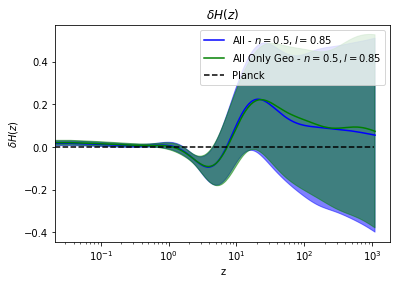

In [57]:
plt.plot(z_arr,  dH_All_CMB_hp_m, color ='b', label='All - $n = 0.5, l = 0.85$')
plt.fill_between(z_arr, dH_All_CMB_hp_m+dH_All_CMB_hp_s,
                 dH_All_CMB_hp_m-dH_All_CMB_hp_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_hp_m, color ='g', label='All Only Geo - $n = 0.5, l = 0.85$')
plt.fill_between(z_arr, dH_All_CMB_geo_hp_m+dH_All_CMB_geo_hp_s,
                 dH_All_CMB_geo_hp_m-dH_All_CMB_geo_hp_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [58]:
print('All + n = 0.5, l = 0.85 ', np.mean(np.mean(All_CMB_hp['DHz'], 1)), '+/-', np.std(np.mean(All_CMB_hp['DHz'], 1)))
print('All geo + n = 0.5, l = 0.85 ', np.mean(np.mean(All_CMB_geo_hp['DHz'], 1)), '+/-', np.std(np.mean(All_CMB_geo_hp['DHz'], 1)))

All + n = 0.5, l = 0.85  0.07273977426898064 +/- 0.07935337799104611
All geo + n = 0.5, l = 0.85  0.08015121961595009 +/- 0.0812242233831392


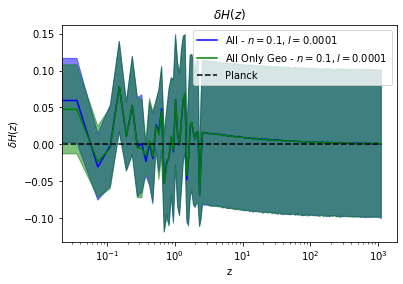

In [62]:
plt.plot(z_arr,  dH_All_CMB_Wm_hp_m, color ='b', label='All - $n = 0.1, l = 0.0001$')
plt.fill_between(z_arr, dH_All_CMB_Wm_hp_m+dH_All_CMB_Wm_hp_s,
                 dH_All_CMB_Wm_hp_m-dH_All_CMB_Wm_hp_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_Wm_hp_m, color ='g', label='All Only Geo - $n = 0.1, l = 0.0001$')
plt.fill_between(z_arr, dH_All_CMB_geo_Wm_hp_m+dH_All_CMB_geo_Wm_hp_s,
                 dH_All_CMB_geo_Wm_hp_m-dH_All_CMB_geo_Wm_hp_s, color='g', alpha=.5)


plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
plt.plot(z_arr,  dH_All_CMB_Wm_hp2_m, color ='m', label='All - $l = 0.0001$')
plt.fill_between(z_arr, dH_All_CMB_Wm_hp2_m+dH_All_CMB_Wm_hp2_s,
                 dH_All_CMB_Wm_hp2_m-dH_All_CMB_Wm_hp2_s, color='m', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
print('All + n = 0.1, l = 0.0001', np.mean(np.mean(All_CMB_Wm_hp['DHz'], 1)), '+/-', np.std(np.mean(All_CMB_Wm_hp['DHz'], 1)))
print('All geo + n = 0.1, l = 0.0001', np.mean(np.mean(All_CMB_geo_Wm_hp['DHz'], 1)), '+/-', np.std(np.mean(All_CMB_geo_Wm_hp['DHz'], 1)))

In [ ]:
plt.plot(z_arr,  dH_All_CMB_Wm_hp2_m, color ='b', label='Fiducial - $l = 0.0001$')
plt.fill_between(z_arr, dH_All_CMB_Wm_hp2_m+dH_All_CMB_Wm_hp2_s,
                 dH_All_CMB_Wm_hp2_m-dH_All_CMB_Wm_hp2_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_Wm_hp2_m, color ='g', label='Only Geo - $l = 0.0001$')
plt.fill_between(z_arr, dH_All_CMB_geo_Wm_hp2_m+dH_All_CMB_geo_Wm_hp2_s,
                 dH_All_CMB_geo_Wm_hp2_m-dH_All_CMB_geo_Wm_hp2_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
plt.plot(z_arr,  dH_All_CMB_Wm_bf_hp2_m, color ='b', label='best fit - $l = 0.0001$')
plt.fill_between(z_arr, dH_All_CMB_Wm_bf_hp2_m+dH_All_CMB_Wm_bf_hp2_s,
                 dH_All_CMB_Wm_bf_hp2_m-dH_All_CMB_Wm_bf_hp2_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_Wm_bf_hp2_m, color ='g', label='best fit Only Geo - $l = 0.0001$')
plt.fill_between(z_arr, dH_All_CMB_geo_Wm_bf_hp2_m+dH_All_CMB_geo_Wm_bf_hp2_s,
                 dH_All_CMB_geo_Wm_bf_hp2_m-dH_All_CMB_geo_Wm_bf_hp2_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
plt.plot(z_arr,  dH_DESI_CMB_Wm_hp2_m, color ='b', label='DESI - $l = 0.0001$')
plt.fill_between(z_arr, dH_DESI_CMB_Wm_hp2_m+dH_DESI_CMB_Wm_hp2_s,
                 dH_DESI_CMB_Wm_hp2_m-dH_DESI_CMB_Wm_hp2_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_DESI_CMB_geo_Wm_hp2_m, color ='g', label='DESI Only Geo - $l = 0.0001$')
plt.fill_between(z_arr, dH_DESI_CMB_geo_Wm_hp2_m+dH_DESI_CMB_geo_Wm_hp2_s,
                 dH_DESI_CMB_geo_Wm_hp2_m-dH_DESI_CMB_geo_Wm_hp2_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
plt.plot(z_arr,  dH_cosmo10_hp2_m, color ='b', label='cosmo10 - $l = 0.0001$')
plt.fill_between(z_arr, dH_cosmo10_hp2_m+dH_cosmo10_hp2_s,
                 dH_cosmo10_hp2_m-dH_cosmo10_hp2_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_cosmo10_noWmnos8_hp2_m, color ='r', label='cosmo10 noWmnos8 - $l = 0.0001$')
plt.fill_between(z_arr, dH_cosmo10_noWmnos8_hp2_m+dH_cosmo10_noWmnos8_hp2_s,
                 dH_cosmo10_noWmnos8_hp2_m-dH_cosmo10_noWmnos8_hp2_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_cosmo10_geo_hp2_m, color ='g', label='Cosmo10 Only Geo - $l = 0.0001$')
plt.fill_between(z_arr, dH_cosmo10_geo_hp2_m+dH_cosmo10_geo_hp2_s,
                 dH_cosmo10_geo_hp2_m-dH_cosmo10_geo_hp2_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
plt.plot(z_arr,  dH_cosmo10_hp_m, color ='b', label='cosmo10 - $n = 0.1, l = 0.0001$')
plt.fill_between(z_arr, dH_cosmo10_hp_m+dH_cosmo10_hp_s,
                 dH_cosmo10_hp_m-dH_cosmo10_hp_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_cosmo10_geo_hp_m, color ='g', label='Cosmo10 Only Geo - $n = 0.1, l = 0.0001$')
plt.fill_between(z_arr, dH_cosmo10_geo_hp_m+dH_cosmo10_geo_hp_s,
                dH_cosmo10_geo_hp_m-dH_cosmo10_geo_hp_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
print('Cosmo10 + Fixed n & l ', np.mean(np.mean(cosmo10_hp['DHz'], 1)), '+/-', np.std(np.mean(cosmo10_hp['DHz'], 1)))
print('Cosmo10 geo + Fixed n & l: ', np.mean(np.mean(cosmo10_geo_hp['DHz'], 1)), '+/-', np.std(np.mean(cosmo10_geo_hp['DHz'], 1)))

In [ ]:
plt.plot(z_arr,  dH_DESI_CMB_Wm_hp3_m, color ='b', label='Fiducial - $n = 0.1, l = 0.0001$')
plt.fill_between(z_arr, dH_DESI_CMB_Wm_hp3_m+dH_DESI_CMB_Wm_hp3_s,
                 dH_DESI_CMB_Wm_hp3_m-dH_DESI_CMB_Wm_hp3_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_DESI_CMB_geo_Wm_hp3_m, color ='g', label='Only Geo - $n = 0.1, l = 0.0001$')
plt.fill_between(z_arr, dH_DESI_CMB_geo_Wm_hp3_m+dH_DESI_CMB_geo_Wm_hp3_s,
                 dH_DESI_CMB_geo_Wm_hp3_m-dH_DESI_CMB_geo_Wm_hp3_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
print('All + Fixed l ', np.mean(All_CMB_Wm_hp2['n']), '+/-', np.std(All_CMB_Wm_hp2['n']))
print('All geo + Fixed l: ', np.mean(All_CMB_geo_Wm_hp2['n']), '+/-', np.std(All_CMB_geo_Wm_hp2['n']))

In [ ]:
np.mean(np.mean(DESI_CMB_Wm_hp3['DHz'], 1))

In [ ]:
print('DESI + Fixed l ', np.mean(DESI_CMB_Wm_hp2['dHz']), '+/-', np.std(DESI_CMB_Wm_hp2['n']))
print('DESI geo + Fixed l: ', np.mean(DESI_CMB_geo_Wm_hp2['n']), '+/-', np.std(DESI_CMB_geo_Wm_hp2['n']))

In [ ]:
print('DESI + Fixed n & l ', np.mean(np.mean(DESI_CMB_Wm_hp3['DHz'], 1)), '+/-', np.std(np.mean(DESI_CMB_Wm_hp3['DHz'], 1)))
print('DESI geo + Fixed n & l: ', np.mean(np.mean(DESI_CMB_geo_Wm_hp3['DHz'], 1)), '+/-', np.std(np.mean(DESI_CMB_geo_Wm_hp3['DHz'], 1)))

In [ ]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_WFIRST_CMB_m, color ='y', label='WFIRST+CMB')
plt.fill_between(z_arr, dH_WFIRST_CMB_m+dH_WFIRST_CMB_s,
                 dH_WFIRST_CMB_m-dH_WFIRST_CMB_s, color='y', alpha=.5)

plt.plot(z_arr,  dH_DESI_CMB_m, color ='b', label='DESI+CMB')
plt.fill_between(z_arr, dH_DESI_CMB_m+dH_DESI_CMB_s,
                 dH_DESI_CMB_m-dH_DESI_CMB_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
print('Current: ', np.mean(All_CMB['n']), '+/-', np.std(All_CMB['n']))
print('DESI+CMB: ', np.mean(DESI_CMB['n']), '+/-', np.std(DESI_CMB['n']))
print('WFIRST: ', np.mean(WFIRST_CMB['n']), '+/-', np.std(WFIRST_CMB['n']))

# H_gp, DM_gp and f$\sigma_8$_gp

## Load samples

In [ ]:
H_DESI_CMB_m, H_DESI_CMB_s = get_m_s(DESI_CMB['Hz'])
H_WFIRST_CMB_m, H_WFIRST_CMB_s = get_m_s(WFIRST_CMB['Hz'])
H_All_m, H_All_s = get_m_s(All['Hz'])
H_All_CMB_m, H_All_CMB_s = get_m_s(All_CMB['Hz'])
H_All_CMB_hp_m, H_All_CMB_hp_s = get_m_s(All_CMB_hp['Hz'])
H_All_CMB_fm_m, H_All_CMB_fm_s = get_m_s(All_CMB_fm['Hz'])
H_All_CMB_geo_m, H_All_CMB_geo_s = get_m_s(All_CMB_geo['Hz'])
H_All_CMB_gro_m, H_All_CMB_gro_s = get_m_s(All_CMB_gro['Hz'])
H_SDSS_CMB_m, H_SDSS_CMB_s = get_m_s(SDSS_CMB['Hz'])
H_Add_CMB_m, H_Add_CMB_s = get_m_s(Add_CMB['Hz'])

In [ ]:
dM_DESI_CMB_m, dM_DESI_CMB_s = get_m_s(DESI_CMB['dMz'])
dM_All_m, dM_All_s = get_m_s(All['dMz'])
dM_All_CMB_m, dM_All_CMB_s = get_m_s(All_CMB['dMz'])
dM_All_CMB_hp_m, dM_All_CMB_hp_s = get_m_s(All_CMB_hp['dMz'])
dM_All_CMB_fm_m, dM_All_CMB_fm_s = get_m_s(All_CMB_fm['dMz'])
dM_SDSS_CMB_m, dM_SDSS_CMB_s = get_m_s(SDSS_CMB['dMz'])
dM_Add_CMB_m, dM_Add_CMB_s = get_m_s(Add_CMB['dMz'])

In [ ]:
fs8_DESI_CMB_m, fs8_DESI_CMB_s = get_m_s(DESI_CMB['fs8z'])
fs8_All_m, fs8_All_s = get_m_s(All['fs8z'])
fs8_All_gro_m, fs8_All_gro_s = get_m_s(All_gro['fs8z'])
fs8_All_gro_noWm_m, fs8_All_gro_noWm_s = get_m_s(All_gro_noWm['fs8z'])
fs8_All_CMB_m, fs8_All_CMB_s = get_m_s(All_CMB['fs8z'])
fs8_All_CMB_noWm_m, fs8_All_CMB_noWm_s = get_m_s(All_CMB_noWm['fs8z'])
fs8_All_CMB_fm_m, fs8_All_CMB_fm_s = get_m_s(All_CMB_fm['fs8z'])
fs8_All_CMB_gro_m, fs8_All_CMB_gro_s = get_m_s(All_CMB_gro['fs8z'])
fs8_All_CMB_gro_hp_m, fs8_All_CMB_gro_hp_s = get_m_s(All_CMB_gro_hp['fs8z'])
fs8_All_CMB_hp_m, fs8_All_CMB_hp_s = get_m_s(All_CMB_hp['fs8z'])
fs8_SDSS_CMB_m, fs8_SDSS_CMB_s = get_m_s(SDSS_CMB['fs8z'])
fs8_Add_CMB_m, fs8_Add_CMB_s = get_m_s(Add_CMB['fs8z'])

## Plots

In [ ]:
fig=plt.figure(figsize=(20,4))
fig.subplots_adjust(wspace=0.15)

ax1 = plt.subplot(131)
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')
plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='ko', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='ks', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s, H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  H_All_CMB_hp_m, color ='k', label='Fixed HP')
plt.fill_between(z_arr, H_All_CMB_hp_m+H_All_CMB_hp_s,
                 H_All_CMB_hp_m-H_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  H_All_CMB_fm_m, color ='b', label='Free $\Omega_m^{mean}$')
plt.fill_between(z_arr, H_All_CMB_fm_m+H_All_CMB_fm_s,
                 H_All_CMB_fm_m-H_All_CMB_fm_s, color='b', alpha=.5)
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
ax2 = plt.subplot(132)

plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='ko', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='ks', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='ko', label='CMB')

plt.plot(z_arr,  dM_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s, dM_All_CMB_m-dM_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_All_CMB_hp_m, color ='k', label='Fixed HP')
plt.fill_between(z_arr, dM_All_CMB_hp_m+dM_All_CMB_hp_s,
                 dM_All_CMB_hp_m-dM_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  dM_All_CMB_fm_m, color ='b', label='Free $\Omega_m^{mean}$')
plt.fill_between(z_arr, dM_All_CMB_fm_m+dM_All_CMB_fm_s,
                 dM_All_CMB_fm_m-dM_All_CMB_fm_s, color='b', alpha=.5)

plt.xlabel("z")
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

ax3 = plt.subplot(133)
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')


plt.plot(z_arr,  fs8_All_CMB_fm_m, color ='b', label='Free $\Omega_m^{mean}$')
plt.fill_between(z_arr, fs8_All_CMB_fm_m+fs8_All_CMB_fm_s,
                 fs8_All_CMB_fm_m-fs8_All_CMB_fm_s, color='b', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_hp_m, color ='k', label='Fixed HP')
plt.fill_between(z_arr, fs8_All_CMB_hp_m+fs8_All_CMB_hp_s,
                 fs8_All_CMB_hp_m-fs8_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();



os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/tests_cosmo_functions.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/tests_cosmo_functions.pdf')  

In [ ]:
fig=plt.figure(figsize=(20,4))
fig.subplots_adjust(wspace=0.15)

ax1 = plt.subplot(131)

plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='bs', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s,
                 H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  H_SDSS_CMB_m, color ='g', label='SDSS+CMB')
plt.fill_between(z_arr, H_SDSS_CMB_m+H_SDSS_CMB_s, 
                 H_SDSS_CMB_m-H_SDSS_CMB_s, color='g', alpha=.5)

plt.plot(z_arr,  H_Add_CMB_m, color ='k', label='Add+CMB')
plt.fill_between(z_arr, H_Add_CMB_m+H_Add_CMB_s,
                 H_Add_CMB_m-H_Add_CMB_s, color='k', alpha=.5)
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

ax2 = plt.subplot(132)
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')
plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='bo', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='bs', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='bo', label='CMB')
plt.plot(z_arr,  dM_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s,
                 dM_All_CMB_m-dM_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_SDSS_CMB_m, color ='g', label='SDSS+CMB')
plt.fill_between(z_arr, dM_SDSS_CMB_m+dM_SDSS_CMB_s,
                 dM_SDSS_CMB_m-dM_SDSS_CMB_s, color='g', alpha=.5)
plt.plot(z_arr,  dM_Add_CMB_m, color ='k', label='Add+CMB')
plt.fill_between(z_arr, dM_Add_CMB_m+dM_Add_CMB_s,
                 dM_Add_CMB_m-dM_Add_CMB_s, color='k', alpha=.5)
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.xscale('log')
plt.yscale('log')
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

ax2 = plt.subplot(133)
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='bs', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='bo', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='bo', label='DSS')

plt.plot(z_arr,  fs8_Add_CMB_m, color ='k', label='Add+CMB')
plt.fill_between(z_arr, fs8_Add_CMB_m+fs8_Add_CMB_s,
                 fs8_Add_CMB_m-fs8_Add_CMB_s, color='k', alpha=.5)

plt.plot(z_arr,  fs8_SDSS_CMB_m, color ='g', label='SDSS+CMB')
plt.fill_between(z_arr, fs8_SDSS_CMB_m+fs8_SDSS_CMB_s,
                 fs8_SDSS_CMB_m-fs8_SDSS_CMB_s, color='g', alpha=.5)

plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)

plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data_cosmo_functions.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data_cosmo_functions.pdf')  

In [ ]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')


plt.plot(z_arr,  fs8_All_CMB_noWm_m, color ='g', label='Fiducial + Fixed $\omega_m$')
plt.fill_between(z_arr, fs8_All_CMB_noWm_m+fs8_All_CMB_noWm_s,
                 fs8_All_CMB_noWm_m-fs8_All_CMB_noWm_s, color='g', alpha=.5)

plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf')  

In [ ]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')


plt.plot(z_arr,  fs8_All_gro_noWm_m, color ='m', label='Growth data + Fixed $\omega_m$')
plt.fill_between(z_arr, fs8_All_gro_noWm_m+fs8_All_gro_noWm_s,
                 fs8_All_gro_noWm_m-fs8_All_gro_noWm_s, color='m', alpha=.5)

plt.plot(z_arr,  fs8_All_gro_m, color ='r', label='Growth data')
plt.fill_between(z_arr, fs8_All_gro_m+fs8_All_gro_s,
                 fs8_All_gro_m-fs8_All_gro_s, color='r', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf')  